In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [233]:
fontsize_legend = 20
fontsize_axes = 24
fontsize_ticks = 16
linewidth_all = 3
markersize_all = 8
size_extra = 4

figsize_whole = (10,6)
folder_out = 'data_processed'

def get_data(proj_name, sim_dir):
    data_dir = 'data_out'
    x_all = np.loadtxt(f"{data_dir}/{proj_name}_x_all.txt")
    y_all = np.loadtxt(f"{data_dir}/{proj_name}_y_all.txt")
    z_all = np.loadtxt(f"{data_dir}/{proj_name}_z_all.txt")
    t_all = np.loadtxt(f"{data_dir}/{proj_name}_t_all.txt")

    vol_all, p_all = np.loadtxt(f'{data_dir}/{proj_name}_pcav_cvol.txt', unpack = True)
    try:
        H, R, t1, t2, _, w, E1, E2, E_cap, _ = np.loadtxt(f'{data_dir}/{proj_name}_props.txt')
    except:
        H, R, t1, t2, _, w, E1, E2, E_cap, _ = np.loadtxt(f'{sim_dir}/{proj_name}_lin_buckling_parameters.txt', skiprows = 1)
    vol_cylinder = H * R * R * np.pi

    if np.abs(vol_all[0]/vol_cylinder - 1) > 0.01:
        raise ValueError("fluid-cavity is calculated wrong")
    
    vol_norm = -(vol_all  - vol_all[0]) / vol_all[0]
    p_kpa = p_all * 1e3 #changing units from MPa to kPa to match w/ exp

    return (t_all, x_all, y_all, z_all, vol_norm, p_kpa, t1)

def find_last_valid_frame(z_all):
    #note: this might not work in general if there's a sharper discontinunity later so be aware
    return np.argmax(np.diff(np.std(z_all, axis = 0), prepend = 0))

def calc_phase(x0, y0):
    phase_all = np.zeros(len(x0))
    for i in range(len(x0)):
        tan_temp = np.arctan2(y0[i],x0[i])
        if tan_temp < 0:
            phase_all[i] = tan_temp + 2*np.pi
        else:
            phase_all[i] = tan_temp
    return phase_all

def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c

def fit_sin(phase_all, disp_r):
    # https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
    fft_disp_r = np.fft.rfft(disp_r - np.mean(disp_r))
    freq_all = np.fft.rfftfreq(disp_r.size, d = 1/disp_r.size)
    freq = freq_all[np.argmax(np.abs(fft_disp_r))]
    print(freq)

    sin_fit = lambda t, A, p, c: sinfunc(t, A, freq, p, c)

    guess_amp = np.std(disp_r) * 2.**0.5
    guess_offset = np.mean(disp_r)
    guess_initial = np.array([guess_amp, 0., guess_offset])

    popt, pcov = curve_fit(sin_fit, phase_all, disp_r, p0 = guess_initial)
    A, p, c = popt
    w = freq
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess_initial,popt,pcov)}

def find_phase_initial_min(A,w,p):
    if A > 0: n = 3
    else: n = 1
    return (n * np.pi/2 - p)/w

def compute_idx_cut(x_all, y_all, z_all):
    frame_idx = find_last_valid_frame(z_all)
    phase_all = calc_phase(x_all[:,0], y_all[:,0])
    disp_r = np.linalg.norm(np.array([x_all[:,frame_idx], y_all[:,frame_idx]]), axis = 0) - np.linalg.norm(np.array([x_all[:,0], y_all[:,0]]), axis = 0)
    fit_data = fit_sin(phase_all, disp_r)

    phase_initial_min = find_phase_initial_min(fit_data['amp'], fit_data['omega'], fit_data['phase'])
    idx_cut = [np.argmin(np.abs(phase_all - (phase_initial_min + phi))) for phi in [0, fit_data['period']]]
    idx_max = np.argmin(np.abs(phase_all - (phase_initial_min + fit_data['period']/2)))

    return (idx_cut, idx_max)
def get_single_wedge_rot(x_all, y_all, frame, idx_cut, idx_max):
    x_sp, y_sp = (x_all[idx_cut[0]:idx_cut[1],frame].copy(), y_all[idx_cut[0]:idx_cut[1],frame].copy())

    theta_rot = np.pi/2 - np.arctan2(y_all[idx_max,frame],x_all[idx_max,frame])
    rotation_matrix = np.array([[np.cos(theta_rot), -np.sin(theta_rot)],[np.sin(theta_rot),np.cos(theta_rot)]])

    for i in range(len(x_sp)):
        vec_cur = np.array([x_sp[i],y_sp[i]])
        vec_cur = np.dot(rotation_matrix,vec_cur)
        x_sp[i] = vec_cur[0]
        y_sp[i] = vec_cur[1]
    
    return (x_sp, y_sp)

def compute_moments_area(x_cur, y_cur, thickness):
    centroid_x = np.mean(x_cur)
    centroid_y = np.mean(y_cur)

    I_x = 0
    I_y = 0

    for i in range(len(x_cur)-1):
        #all dist are in mm
        x_dist = x_cur[i] - centroid_x
        y_dist = y_cur[i] - centroid_y

        ell = np.linalg.norm(np.array([x_cur[i+1],y_cur[i+1]]) - np.array([x_cur[i],y_cur[i]]))
        dA = ell * thickness
        I_x += y_dist*y_dist*dA
        I_y += x_dist*x_dist*dA

    return (I_x,I_y)

def process_centernodes(proj_name, sim_dir, cut_idx = True):
    t_all, x_all, y_all, z_all, vol_norm, p_kpa, t1 = get_data(proj_name, sim_dir)
    if cut_idx: frame_idx = find_last_valid_frame(z_all)
    else: frame_idx = len(t_all) - 1
    I_x_all, I_y_all = [np.zeros(frame_idx) for _ in range(2)]
    idx_cut, idx_max = compute_idx_cut(x_all, y_all, z_all)
    for i in range(frame_idx):
        x_sp, y_sp = get_single_wedge_rot(x_all, y_all, i, idx_cut, idx_max)
        I_x_all[i], I_y_all[i] = compute_moments_area(x_sp, y_sp, t1)

    info_all = np.array([t_all[:frame_idx], vol_norm[:frame_idx], p_kpa[:frame_idx], I_x_all, I_y_all])
    np.savetxt(f'{folder_out}/moments_area_{proj_name}.txt', info_all.T, header = 'time | -\Delta V/V_0 | P [kpa] | I_x [mm^4] | I_y [mm^4]')

    return (vol_norm[:frame_idx], I_x_all, I_y_all)

def improve_plot(axis, xlabel = '', ylabel = ''):
    axis.legend(loc = 'best', fontsize = fontsize_legend)
    axis.set_xlabel(xlabel, fontsize = fontsize_axes)
    axis.set_ylabel(ylabel, fontsize = fontsize_axes)
    axis.tick_params(labelsize = fontsize_ticks)

In [201]:
proj_name = '4fold-fitting-554'
t_all, x_all, y_all, z_all, vol_norm, p_kpa, t1 = get_data(proj_name, 'four-folds-sims')
frame_idx = find_last_valid_frame(z_all)
I_x_all, I_y_all = [np.zeros(frame_idx) for _ in range(2)]

for i in range(frame_idx):
    idx_cut, idx_max = compute_idx_cut(x_all, y_all, z_all)
    x_sp, y_sp = get_single_wedge_rot(x_all, y_all, i, idx_cut, idx_max)
    I_x_all[i], I_y_all[i] = compute_moments_area(x_sp, y_sp, t1)

info_all = np.array([t_all[:frame_idx], vol_norm[:frame_idx], p_kpa[:frame_idx], I_x_all, I_y_all])
np.savetxt(f'{folder_out}/moments_area_{proj_name}.txt', info_all.T, header = 'time | -\Delta V/V_0 | P [kpa] | I_x [mm^4] | I_y [mm^4]')

4.0


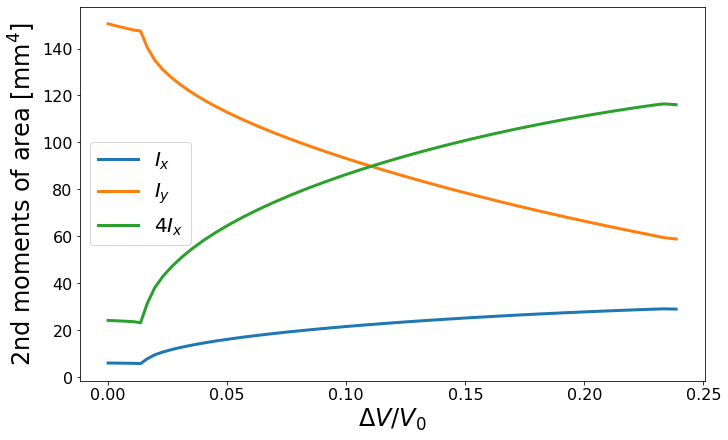

In [237]:
proj_name = '4fold-fitting-554'
sim_dir = 'four-folds-sims'
vol_plot, I_x_all, I_y_all = process_centernodes(proj_name, sim_dir)

fig, ax = plt.subplots(figsize = figsize_whole, constrained_layout = True)
ax.plot(vol_plot, I_x_all, label = '$I_x$', linewidth = linewidth_all)
ax.plot(vol_plot, I_y_all, label = '$I_y$', linewidth = linewidth_all)
ax.plot(vol_plot, 4*I_x_all, label = '$4I_x$', linewidth = linewidth_all)

improve_plot(ax, xlabel = '$\Delta V/V_0$', ylabel = '2nd moments of area [mm$^4$]')


fig.savefig(f'{folder_out}/moments_area_{proj_name}.png', facecolor = 'white')

3.0


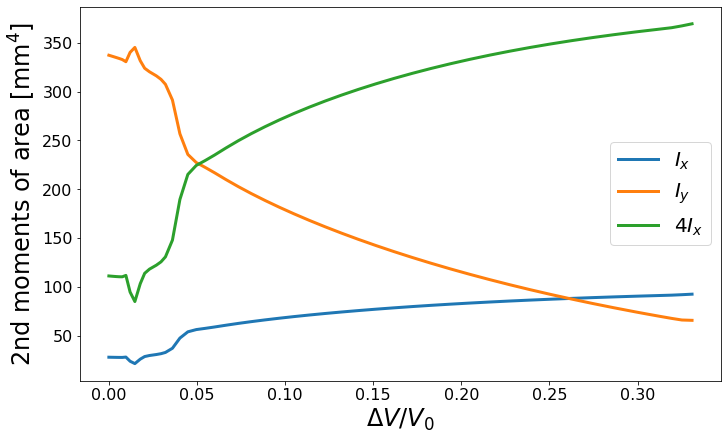

In [235]:
proj_name = '3fold-fitting-666'
sim_dir = 'three-folds-sims'
vol_plot, I_x_all, I_y_all = process_centernodes(proj_name, sim_dir)

fig, ax = plt.subplots(figsize = figsize_whole, constrained_layout = True)
ax.plot(vol_plot, I_x_all, label = '$I_x$', linewidth = linewidth_all)
ax.plot(vol_plot, I_y_all, label = '$I_y$', linewidth = linewidth_all)
ax.plot(vol_plot, 4*I_x_all, label = '$4I_x$', linewidth = linewidth_all)

improve_plot(ax, xlabel = '$\Delta V/V_0$', ylabel = '2nd moments of area [mm$^4$]')

fig.savefig(f'{folder_out}/moments_area_{proj_name}.png', facecolor = 'white')

2.0


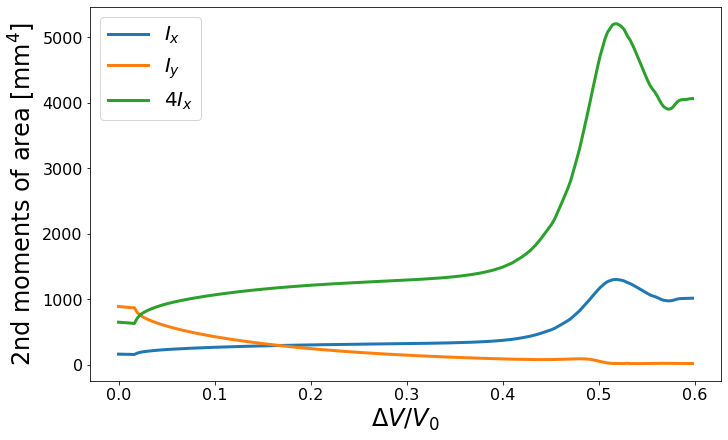

In [236]:
proj_name = '2fold-fitting-557'
sim_dir = 'two-folds-sims'
vol_plot, I_x_all, I_y_all = process_centernodes(proj_name, sim_dir, cut_idx = False)

fig, ax = plt.subplots(figsize = figsize_whole, constrained_layout = True)
ax.plot(vol_plot, I_x_all, label = '$I_x$', linewidth = linewidth_all)
ax.plot(vol_plot, I_y_all, label = '$I_y$', linewidth = linewidth_all)
ax.plot(vol_plot, 4*I_x_all, label = '$4I_x$', linewidth = linewidth_all)

improve_plot(ax, xlabel = '$\Delta V/V_0$', ylabel = '2nd moments of area [mm$^4$]')


fig.savefig(f'{folder_out}/moments_area_{proj_name}.png', facecolor = 'white')